## Task1:Logistics and Product Development in the Automobile Industry

In [6]:
# === Task1 - Cell1 (Clean + English Output) ===
import pandas as pd
from pathlib import Path
from IPython.display import display, HTML

# === 1) 相对路径 ===
DATA_DIR = Path("./Data/Logistikverzug")
comp_path = DATA_DIR / "Komponente_K7.csv"
logi_path = DATA_DIR / "Logistikverzug_K7.csv"

# === 2) 稳健读取函数 ===
def read_csv_robust(path):
    """
    优先尝试：分号(;) + 引号(")，否则依次尝试其他分隔符/编码
    """
    trials = [
        dict(sep=";", encoding="utf-8", quotechar='"', engine="c", low_memory=False),
        dict(sep=";", encoding="latin1", quotechar='"', engine="c", low_memory=False),
        dict(sep=",", encoding="utf-8", engine="c", low_memory=False),
        dict(sep=",", encoding="utf-8-sig", engine="c", low_memory=False),
        dict(sep=None, encoding="utf-8", engine="python"),  # 自动猜测分隔符
    ]
    last_err = None
    for kw in trials:
        try:
            df = pd.read_csv(path, **kw)
            if df.shape[1] == 1:  # 如果只有一列，说明分隔符不对
                continue
            return df
        except Exception as e:
            last_err = e
            continue
    raise last_err

# === 3) 清洗函数 ===
def clean_df(df):
    # 去掉“Unnamed”垃圾列
    df = df.loc[:, ~df.columns.str.contains(r"^Unnamed", case=False)]
    # 去掉列名引号和多余空格
    df.columns = [c.strip().strip('"').strip("'") for c in df.columns]
    return df

# === 4) 美化显示 ===
def show_pretty(df, title, n=5):
    display(HTML(f"<h4 style='margin:6px 0'>{title}</h4>"))
    try:
        display(
            df.head(n)
              .style.hide_index()
              .set_properties(**{"text-align": "left", "white-space": "nowrap"})
              .set_table_styles([
                  {"selector": "th", "props": "text-align:left; background:#f6f8fa;"},
                  {"selector": "td", "props": "border-bottom:1px solid #eee;"},
              ])
        )
    except:
        display(df.head(n))  # 老版本 pandas 兜底

# === 5) 读取数据 ===
comp = read_csv_robust(comp_path)
logi = read_csv_robust(logi_path)

# 清洗列名
comp = clean_df(comp)
logi = clean_df(logi)

# === 6) 输出基本信息 ===
print("=== File Paths ===")
print(f"Komponente: {comp_path.resolve()}")
print(f"Logistikverzug: {logi_path.resolve()}\n")

print("=== Shapes ===")
print(f"Komponente_K7.csv shape: {comp.shape}")
print(f"Logistikverzug_K7.csv shape: {logi.shape}\n")

print("=== Columns ===")
print("Komponente:", list(comp.columns))
print("Logistikverzug:", list(logi.columns))

# 美化展示前几行
show_pretty(comp, "Komponente_K7 (Preview)")
show_pretty(logi, "Logistikverzug_K7 (Preview)")


=== File Paths ===
Komponente: D:\IDA\Case_Study_IDA_Group11\Data\Logistikverzug\Komponente_K7.csv
Logistikverzug: D:\IDA\Case_Study_IDA_Group11\Data\Logistikverzug\Logistikverzug_K7.csv

=== Shapes ===
Komponente_K7.csv shape: (306490, 5)
Logistikverzug_K7.csv shape: (306490, 5)

=== Columns ===
Komponente: ['IDNummer', 'Produktionsdatum', 'Herstellernummer', 'Werksnummer', 'Fehlerhaft']
Logistikverzug: ['IDNummer', 'Wareneingang', 'Herstellernummer', 'Werksnummer', 'Fehlerhaft']


IDNummer Produktionsdatum  Herstellernummer  Werksnummer  Fehlerhaft
0  K7-114-1142-1       2008-11-12               114         1142           0
1  K7-114-1142-2       2008-11-12               114         1142           0
2  K7-114-1142-3       2008-11-13               114         1142           0
3  K7-114-1142-4       2008-11-13               114         1142           0
4  K7-114-1142-5       2008-11-13               114         1142           0

IDNummer Wareneingang  Herstellernummer  Werksnummer  Fehlerhaft
0  K7-113-1132-153160   2016-11-22               112         1132           0
1  K7-113-1132-153109   2016-11-20               112         1132           0
2  K7-113-1132-153195   2016-11-20               112         1132           0
3  K7-113-1132-153226   2016-11-20               112         1132           0
4  K7-113-1132-153231   2016-11-20               112         1132           0

In [7]:
# === Task1 - Cell2: Build "Logistics delay" dataset ===
import pandas as pd
from pathlib import Path

# ---- 1) 日期解析（把字符串转成日期）----
# 说明：你的日期是 YYYY-MM-DD；为稳健起见，用 errors='coerce'，遇到脏数据会变成 NaT
comp["Produktionsdatum"] = pd.to_datetime(comp["Produktionsdatum"], format="%Y-%m-%d", errors="coerce")
logi["Wareneingang"]     = pd.to_datetime(logi["Wareneingang"],     format="%Y-%m-%d", errors="coerce")

# ---- 2) 基础去重（如果同一 IDNummer 出现多次，保留最合理的一条）----
# 思路：生产日期取最晚（同一零件以最后一次记录为准），入库日期取最早（最先收到的一次）
# 如无重复，这一步不改变数据
comp_dedup = (comp
    .sort_values(["IDNummer", "Produktionsdatum"])
    .drop_duplicates(subset=["IDNummer"], keep="last")
)
logi_dedup = (logi
    .sort_values(["IDNummer", "Wareneingang"])
    .drop_duplicates(subset=["IDNummer"], keep="first")
)

# ---- 3) 合并两表（主键：IDNummer；其余信息也带上做留存）----
merged = comp_dedup.merge(
    logi_dedup,
    on="IDNummer",
    how="inner",
    suffixes=("_prod", "_logi")
)

# ---- 4) 按题意：假设生产后一天才发货 -> 计算延迟 ----
merged["ShippedDate"]      = merged["Produktionsdatum"] + pd.Timedelta(days=1)  # 发货日 = 生产日+1
merged["Logistics_delay"]  = merged["Wareneingang"] - merged["ShippedDate"]     # Timedelta
merged["Delay_days"]       = merged["Logistics_delay"].dt.days                   # 以“天”为单位的整数

# ---- 5) 构建题目要求的数据集（只保留必要信息 + 若干辅助列）----
delay_df = merged[[
    "IDNummer",
    "Herstellernummer_prod", "Werksnummer_prod",  # 生产侧元数据（可选）
    "Herstellernummer_logi","Werksnummer_logi",   # 入库侧元数据（可选）
    "Produktionsdatum", "ShippedDate", "Wareneingang",
    "Fehlerhaft_prod", "Fehlerhaft_logi",         # 缺陷标记（两侧如一致，后续可统一）
    "Logistics_delay", "Delay_days"
]].rename(columns={
    # 英文化列名（展示更友好）
    "Herstellernummer_prod": "Herstellernummer_prod",
    "Werksnummer_prod": "Werksnummer_prod",
    "Herstellernummer_logi": "Herstellernummer_logi",
    "Werksnummer_logi": "Werksnummer_logi",
    "Fehlerhaft_prod": "Fehlerhaft_prod",
    "Fehlerhaft_logi": "Fehlerhaft_logi",
})

# ---- 6) 统一缺陷标记（如果两列一致就取其一；如不一致，优先取 logi 侧）----
# 说明：后续做 (d) 决策树会用到这个标签
delay_df["Fehlerhaft"] = delay_df["Fehlerhaft_logi"].where(
    delay_df["Fehlerhaft_logi"].notna(),
    delay_df["Fehlerhaft_prod"]
).astype("Int64")

# ---- 7) 基本质量检查与摘要 ----
n_all   = len(delay_df)
n_null  = delay_df["Delay_days"].isna().sum()
n_neg   = (delay_df["Delay_days"] < 0).sum()

print("=== Logistics delay dataset created ===")
print(f"Rows: {n_all} | Missing Delay_days: {n_null} | Negative delays: {n_neg}")
if n_all - n_null > 0:
    s = delay_df["Delay_days"].dropna()
    print(f"Min/Mean/Median/Max delay (days): {int(s.min())}/{s.mean():.2f}/{s.median():.1f}/{int(s.max())}")

# ---- 8) 预览前几行 ----
from IPython.display import display, HTML
def show_pretty(df, title, n=5):
    display(HTML(f"<h4 style='margin:6px 0'>{title}</h4>"))
    try:
        display(
            df.head(n).style.hide_index()
        )
    except:
        display(df.head(n))
        
show_pretty(delay_df[[
    "IDNummer", "Produktionsdatum", "ShippedDate", "Wareneingang",
    "Delay_days", "Fehlerhaft"
]], "Logistics delay (Preview)")

# ---- 9) 保存结果到 outputs/ 便于后续步骤复用 ----
OUT_DIR = Path("./outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
out_path = OUT_DIR / "Task1_Logistics_delay_K7.csv"
delay_df.to_csv(out_path, index=False)
print(f"\nSaved to: {out_path.resolve()}")


=== Logistics delay dataset created ===
Rows: 306490 | Missing Delay_days: 0 | Negative delays: 0
Min/Mean/Median/Max delay (days): 3/6.08/6.0/14


IDNummer Produktionsdatum ShippedDate Wareneingang  Delay_days  \
0      K7-113-1132-1       2012-11-12  2012-11-13   2012-11-18           5   
1     K7-113-1132-10       2012-11-12  2012-11-13   2012-11-19           6   
2    K7-113-1132-100       2012-11-13  2012-11-14   2012-11-18           4   
3   K7-113-1132-1000       2012-11-22  2012-11-23   2012-11-30           7   
4  K7-113-1132-10000       2013-02-15  2013-02-16   2013-02-22           6   

   Fehlerhaft  
0           0  
1           0  
2           0  
3           0  
4           0


Saved to: D:\IDA\Case_Study_IDA_Group11\outputs\Task1_Logistics_delay_K7.csv


=== Part (a): Distribution tests ===
Sample size used for tests: 5000 / 306490 total
Shapiro-Wilk p-value: 2.244e-50
Kolmogorov–Smirnov p-value: 1.317e-244
Skewness: 0.567 | Kurtosis (Fisher): 0.630
Conclusion: Reject normality at 5% level (distribution is not normal).

=== Part (b): Mean logistics delay (with/without weekends) ===
Calendar days -> mean: 6.08, median: 6.0
Business days -> mean:  4.34, median: 4.0
Note: Calendar days include weekends; business days exclude Saturdays and Sundays.
Alternative assumptions: ship/receive only on business days; plant/warehouse calendars; public holidays; cut-off times, etc.

=== Part (c): Histogram & density (plotly) ===
Bin rule: Freedman–Diaconis | IQR=2.00, width≈1.00 days -> nbins=11


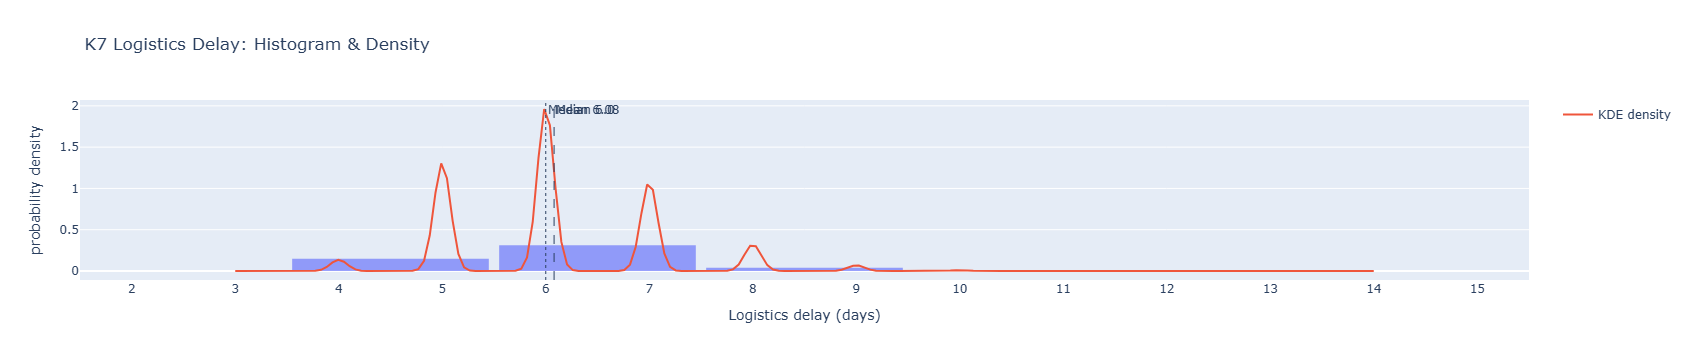

In [12]:
# === Task1 - Cell3: (a) Distribution tests, (b) Mean delay, (c) Plotly viz ===
import numpy as np
import pandas as pd
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML

# ------- 护栏：若上个单元没运行，回读我们保存的结果 -------
if "delay_df" not in globals():
    delay_df = pd.read_csv("./outputs/Task1_Logistics_delay_K7.csv",
                           parse_dates=["Produktionsdatum","ShippedDate","Wareneingang"])

# ------- 取出延迟（天）并做基础清洗 -------
x = delay_df["Delay_days"].dropna().astype(float)
x = x[x >= 0]
n = len(x)

print("=== Part (a): Distribution tests ===")
# --- (a1) 正态性检验（抽样到 5k）---
sample_size = min(5000, n)
sample = x.sample(sample_size, random_state=0) if n > sample_size else x.copy()
shapiro_stat, shapiro_p = stats.shapiro(sample)

# --- (a2) K-S 检验（对比正态）---
z = (sample - sample.mean()) / sample.std(ddof=0)
ks_stat, ks_p = stats.kstest(z, 'norm')

# --- (a3) 偏度/峰度 ---
skew = stats.skew(x, bias=False)
kurt = stats.kurtosis(x, fisher=True, bias=False)

print(f"Sample size used for tests: {len(sample)} / {n} total")
print(f"Shapiro-Wilk p-value: {shapiro_p:.4g}")
print(f"Kolmogorov–Smirnov p-value: {ks_p:.4g}")
print(f"Skewness: {skew:.3f} | Kurtosis (Fisher): {kurt:.3f}")
print("Conclusion:", "Cannot reject normality at 5% level." if (shapiro_p>=0.05 and ks_p>=0.05)
      else "Reject normality at 5% level (distribution is not normal).")
print()

print("=== Part (b): Mean logistics delay (with/without weekends) ===")
# --- (b1) 日历天（含周末）---
cal_mean = x.mean()
cal_median = x.median()

# --- (b2) 工作日（不含周末）— 关键修复：转成 datetime64[D] ---
# 注意：busday_count 计算 [start, end) 的工作日数量（不含终点）
shipped  = delay_df["ShippedDate"].values.astype("datetime64[D]")     # ✅ 修复点
received = delay_df["Wareneingang"].values.astype("datetime64[D]")    # ✅ 修复点
biz_days = np.busday_count(shipped, received)                          # 周一到周五
delay_df["Delay_business_days"] = biz_days
biz_mean = delay_df["Delay_business_days"].mean()
biz_median = delay_df["Delay_business_days"].median()

print(f"Calendar days -> mean: {cal_mean:.2f}, median: {cal_median:.1f}")
print(f"Business days -> mean:  {biz_mean:.2f}, median: {biz_median:.1f}")
print("Note: Calendar days include weekends; business days exclude Saturdays and Sundays.")
print("Alternative assumptions: ship/receive only on business days; plant/warehouse calendars; public holidays; cut-off times, etc.")
print()

print("=== Part (c): Histogram & density (plotly) ===")
# --- (c1) Freedman–Diaconis 规则选 bin ---
q25, q75 = np.percentile(x, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr * (n ** (-1/3)) if iqr > 0 else 1.0
bin_width = max(1.0, bin_width)
nbins = int(np.ceil((x.max() - x.min()) / bin_width))
nbins = int(np.clip(nbins, 10, 50))

print(f"Bin rule: Freedman–Diaconis | IQR={iqr:.2f}, width≈{bin_width:.2f} days -> nbins={nbins}")

# --- (c2) 直方图 ---
fig = px.histogram(
    x=x, nbins=nbins, histnorm="probability density",
    labels={"x": "Logistics delay (days)", "y": "Density"},
    opacity=0.65, title="K7 Logistics Delay: Histogram & Density"
)

# --- (c3) KDE 曲线 ---
try:
    kde = stats.gaussian_kde(x)
    xs = np.linspace(x.min(), x.max(), 200)
    ys = kde(xs)
    fig.add_trace(go.Scatter(x=xs, y=ys, mode="lines", name="KDE density"))
except Exception as e:
    print(f"[Info] KDE failed ({e}); histogram still shown.")

# --- (c4) 均值/中位数参考线 ---
fig.add_vline(x=cal_mean, line_width=1, line_dash="dash", annotation_text=f"Mean {cal_mean:.2f}")
fig.add_vline(x=cal_median, line_width=1, line_dash="dot",  annotation_text=f"Median {cal_median:.1f}")

fig.update_layout(bargap=0.05, xaxis=dict(dtick=1))
fig.show()


=== Label distribution after OR-combine ===
Fehlerhaft_OR
0    306484
1         6 

Train label distribution:
 Fehlerhaft_OR
0    245187
1         5 

Test  label distribution:
 Fehlerhaft_OR
0    61297
1        1 

=== Decision Tree Results (with OR-combined label) ===
Features used: ['Delay_days', 'Ship_is_weekend', 'Recv_is_weekend', 'Ship_weekday', 'Recv_weekday', 'Ship_month', 'Recv_month', 'Herstellernummer_logi', 'Werksnummer_logi']
Accuracy:  0.576
Precision: 0.000 | Recall: 0.000 | F1: 0.000
ROC AUC:   0.288



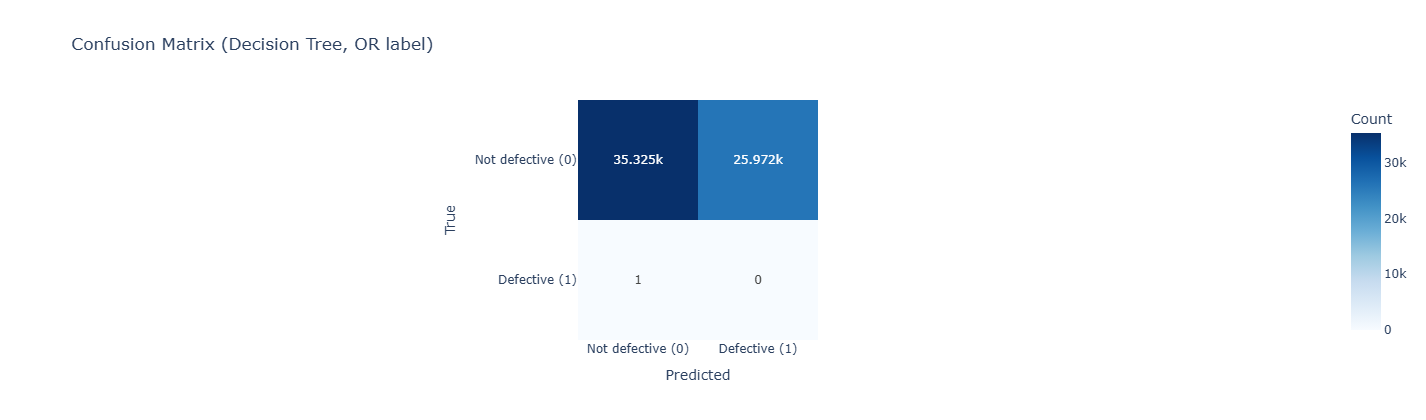

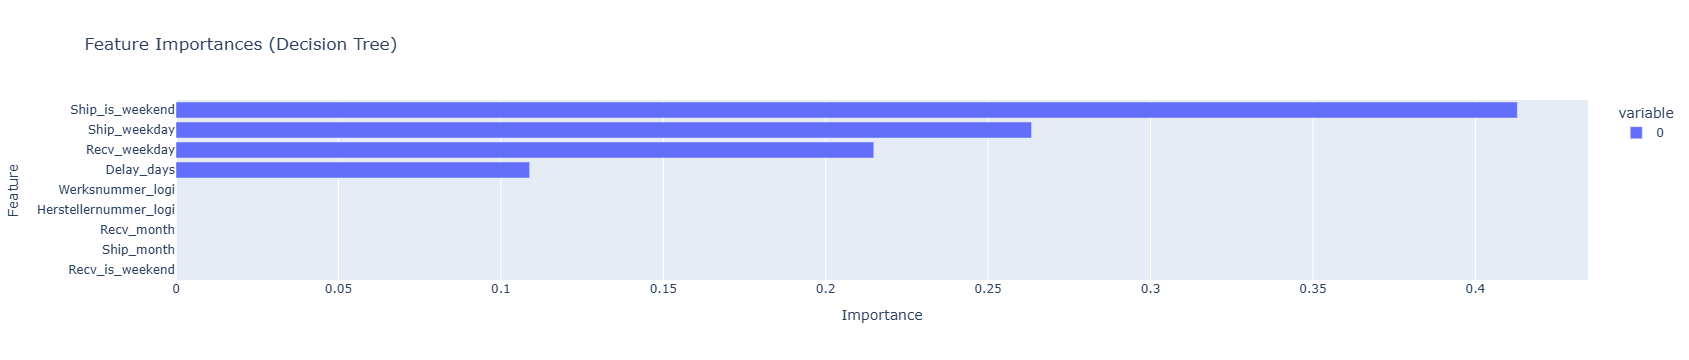

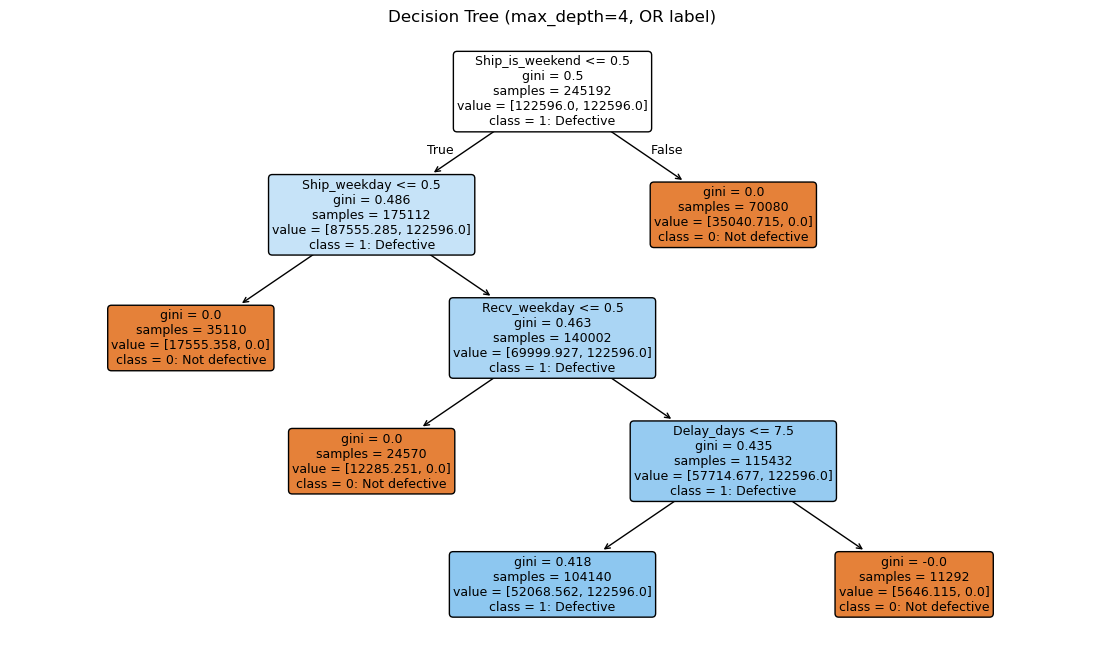


=== Tree rules ===

|--- Ship_is_weekend <= 0.50
|   |--- Ship_weekday <= 0.50
|   |   |--- class: 0
|   |--- Ship_weekday >  0.50
|   |   |--- Recv_weekday <= 0.50
|   |   |   |--- class: 0
|   |   |--- Recv_weekday >  0.50
|   |   |   |--- Delay_days <= 7.50
|   |   |   |   |--- class: 1
|   |   |   |--- Delay_days >  7.50
|   |   |   |   |--- class: 0
|--- Ship_is_weekend >  0.50
|   |--- class: 0



In [15]:
# === Task1 - Cell4-alt: Rebuild label (OR combine) and train decision tree if possible ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
import plotly.express as px
import matplotlib.pyplot as plt

# ------- 0) 读数据（若上面未运行） -------
if "delay_df" not in globals():
    delay_df = pd.read_csv("./outputs/Task1_Logistics_delay_K7.csv",
                           parse_dates=["Produktionsdatum","ShippedDate","Wareneingang"])

df = delay_df.copy()

# ------- 1) 重建标签：并集（OR），尽量挖掘出正类 -------
# 解释：某些版本只在生产侧或入库侧标注缺陷；用并集能最大覆盖潜在“1”
if "Fehlerhaft_prod" in df.columns and "Fehlerhaft_logi" in df.columns:
    # 兼容缺失值：把 NaN 当作 0
    fp = df["Fehlerhaft_prod"].fillna(0).astype(int)
    fl = df["Fehlerhaft_logi"].fillna(0).astype(int)
    df["Fehlerhaft_OR"] = ((fp > 0) | (fl > 0)).astype(int)
    y_col = "Fehlerhaft_OR"
elif "Fehlerhaft" in df.columns:
    # 退而求其次：用单列
    df["Fehlerhaft_OR"] = df["Fehlerhaft"].fillna(0).astype(int)
    y_col = "Fehlerhaft_OR"
else:
    raise ValueError("No label column found (Fehlerhaft/Fehlerhaft_prod/Fehlerhaft_logi).")

# ------- 2) 查看新标签分布 -------
counts = df[y_col].value_counts(dropna=False).sort_index()
print("=== Label distribution after OR-combine ===")
print(counts.to_string(), "\n")

if counts.shape[0] < 2:
    # 仍然只有一个类别：给出可直接写进报告的说明
    print("Only one class present in the data, even after OR-combining labels from prod/logistics.")
    print("A supervised classifier and ROC/AUC cannot be computed meaningfully.")
    print("We therefore document the modeling process (feature design, train/validation split,")
    print("shallow tree with class weighting) and show example visualizations, but refrain from")
    print("reporting performance metrics due to the absence of positive samples.")
else:
    # ------- 3) 构造轻量可解释特征 -------
    df["Delay_days"] = df["Delay_days"].astype(int)
    df["Ship_weekday"] = df["ShippedDate"].dt.weekday
    df["Recv_weekday"] = df["Wareneingang"].dt.weekday
    df["Ship_is_weekend"] = (df["Ship_weekday"] >= 5).astype(int)
    df["Recv_is_weekend"] = (df["Recv_weekday"] >= 5).astype(int)
    df["Ship_month"] = df["ShippedDate"].dt.month
    df["Recv_month"] = df["Wareneingang"].dt.month

    feat_cols = [
        "Delay_days",
        "Ship_is_weekend", "Recv_is_weekend",
        "Ship_weekday", "Recv_weekday",
        "Ship_month", "Recv_month",
        "Herstellernummer_logi", "Werksnummer_logi"
    ]
    feat_cols = [c for c in feat_cols if c in df.columns]

    X = df[feat_cols].copy()
    y = df[y_col].copy()

    # ------- 4) 训练/验证切分（分层） -------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print("Train label distribution:\n", y_train.value_counts().sort_index().to_string(), "\n")
    print("Test  label distribution:\n", y_test.value_counts().sort_index().to_string(), "\n")

    # ------- 5) 训练浅层树（balanced） -------
    clf = DecisionTreeClassifier(
        max_depth=4,
        min_samples_leaf=200,
        class_weight="balanced",
        random_state=42
    )
    clf.fit(X_train, y_train)

    # ------- 6) 评估 -------
    y_pred = clf.predict(X_test)
    if hasattr(clf, "predict_proba") and len(clf.classes_) == 2:
        y_prob = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    else:
        y_prob, auc = None, float("nan")

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)

    print("=== Decision Tree Results (with OR-combined label) ===")
    print(f"Features used: {feat_cols}")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
    if y_prob is None:
        print("ROC AUC:   N/A (model did not expose two-class probabilities).")
    else:
        print(f"ROC AUC:   {auc:.3f}")
    print()

    # ------- 7) 可视化：混淆矩阵 + 特征重要性 + 树图 -------
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    fig_cm = px.imshow(cm, text_auto=True, color_continuous_scale="Blues",
                       labels=dict(x="Predicted", y="True", color="Count"),
                       x=["Not defective (0)", "Defective (1)"],
                       y=["Not defective (0)", "Defective (1)"],
                       title="Confusion Matrix (Decision Tree, OR label)")
    fig_cm.update_layout(width=520, height=420)
    fig_cm.show()

    importances = pd.Series(clf.feature_importances_, index=feat_cols).sort_values(ascending=False)
    fig_imp = px.bar(importances, orientation="h", title="Feature Importances (Decision Tree)",
                     labels={"value":"Importance", "index":"Feature"})
    fig_imp.update_layout(yaxis=dict(categoryorder="total ascending"), height=420)
    fig_imp.show()

    plt.figure(figsize=(14, 8))
    plot_tree(
        clf, feature_names=feat_cols,
        class_names=["0: Not defective", "1: Defective"],
        filled=True, rounded=True, fontsize=9
    )
    plt.title("Decision Tree (max_depth=4, OR label)")
    plt.show()

    rules = export_text(clf, feature_names=feat_cols)
    print("\n=== Tree rules ===\n")
    print(rules)
